Primeras filas del archivo:
     ID           Nombre       Sexo    Centro        Cargo   p1   p2   p3  \
0  1189    Profesional 4   Femenino  Centro 1  Categoría 1  0.6  0.6  0.8   
1  1890   Profesional 97  Masculino  Centro 2  Categoría 1  0.8  0.6  0.8   
2  1440  Profesional 102   Femenino  Centro 3  Categoría 1  0.4  0.6  0.6   
3  1344   Profesional 27   Femenino  Centro 1  Categoría 2  0.8  1.0  0.6   
4  1966   Profesional 31   Femenino  Centro 1  Categoría 2  0.8  0.8  0.8   

    p4   p5   p6   p7   p8   p9  p10  p11  
0  0.6  0.8  0.6  0.6  0.6  0.6  0.6  0.6  
1  0.6  0.6  0.6  0.6  0.8  0.6  1.0  0.8  
2  0.6  0.4  0.8  0.8  0.8  0.6  0.8  0.8  
3  1.0  1.0  0.6  0.8  1.0  0.8  0.6  0.8  
4  0.8  0.8  0.6  0.8  0.8  0.6  0.8  0.8  

Columnas numéricas que se usarán para clustering:
Index(['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11'], dtype='object')


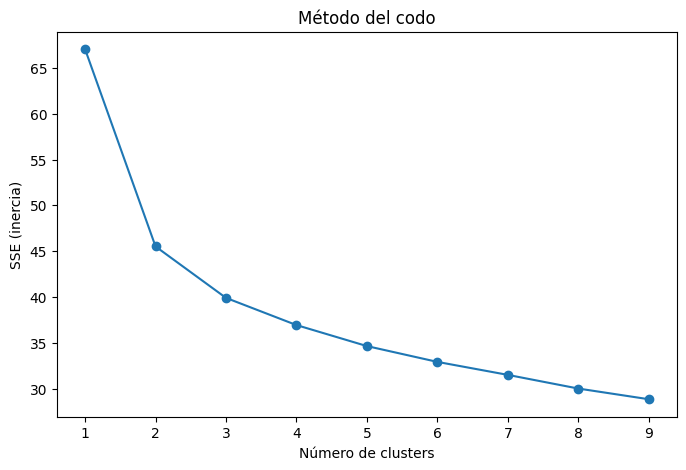

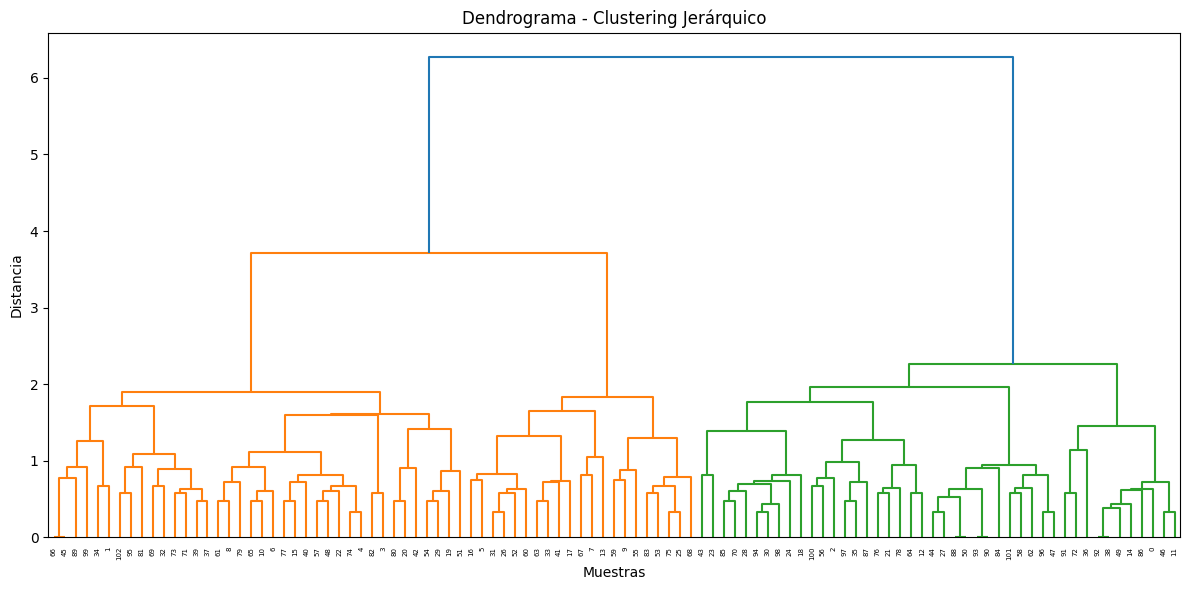


Promedio de cada ítem por cluster:
               p1        p2        p3        p4        p5        p6        p7  \
Cluster                                                                         
0        0.774468  0.753191  0.689362  0.697872  0.791489  0.676596  0.761702   
1        0.939130  0.860870  0.808696  0.834783  0.843478  0.826087  0.878261   
2        0.630303  0.600000  0.539394  0.587879  0.630303  0.593939  0.703030   

               p8        p9       p10       p11  
Cluster                                          
0        0.782979  0.663830  0.685106  0.778723  
1        0.895652  0.808696  0.939130  0.886957  
2        0.660606  0.587879  0.600000  0.666667  

Cantidad de personas por cluster:
Cluster
0    47
2    33
1    23
Name: count, dtype: int64


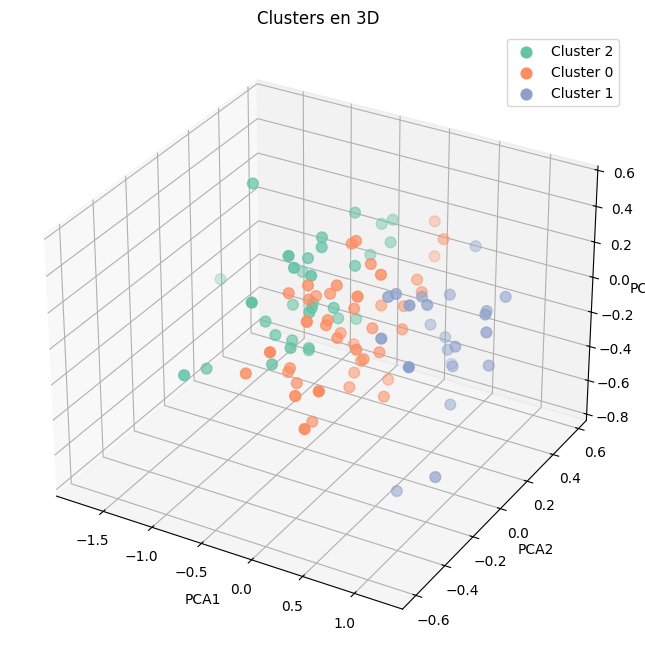


Archivo guardado: /CLUSTER_JJ_con_clusters.xlsx


In [3]:
## Clustering no supervisado para perfilamiento social

# El problema surge de la necesidad de pesquizar necesidades formativas en un grupo de profesionales que se desempeñan en una institución
# Se cuenta con 11 ítems evaluativos, según los cuales se debe realizar la clasificación en grupos, para conocer en qué grado deben ser reforzados los contenidos en cada uno
# De acuerdo con el problema, se utlizará un análisis de clúster jerárquico
# Se utilizó K-means por su eficiencia computacional, interpretabilidad y adecuación para el perfilamiento de sujetos a partir de variables continuas escaladas, permitiendo generar clusters homogéneos y comparables para fines de análisis aplicado y toma de decisiones.
# Este notebook presenta un ejemplo de análisis de clustering no supervisado aplicado al perfilamiento de sujetos a partir de variables cuantitativas, con fines de evaluación y apoyo a la toma de decisiones en contextos sociales y educativos.

# Importar librerías
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage


# Carga de datos desde documento de Excel
file_path = '/ANALISIS CLUSTER EVAL.xlsx'
df = pd.read_excel(file_path)

print("Primeras filas del archivo:")
print(df.head())


# Excluir columnas con código y textos (ID + 2 de texto)
df_items = df.iloc[:, 3:]  # columnas desde la 4ª en adelante


# Seleccionar sólo columnas numéricas
items_numeric = df_items.select_dtypes(include=['number'])

print("\nColumnas numéricas que se usarán para clustering:")
print(items_numeric.columns)


# COn el fin de estandarizar, se escalan los datos en puntaje Z (0-1)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(items_numeric)


# Determinar el número de cluster (Método del codo)
sse = []
k_range = range(1, 10)  # de 1 a 9 clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('SSE (inercia)')
plt.title('Método del codo')
plt.show()


# Dendrograma para clusterización jerárquica
# Usar una muestra si hay demasiadas filas
if X_scaled.shape[0] > 500:
    print(f"Dataset grande ({X_scaled.shape[0]} filas). Usando muestra de 500 para dendrograma.")
    sample = X_scaled[:500]
else:
    sample = X_scaled

linked = linkage(sample, method='ward')

plt.figure(figsize=(12,6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False)
plt.title('Dendrograma - Clustering Jerárquico')
plt.xlabel('Muestras')
plt.ylabel('Distancia')
plt.tight_layout()
plt.show()


# Creación de cluster (ejemplo k=3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)


# Genera promedio de cada item por cluster
cluster_summary = df.groupby('Cluster')[items_numeric.columns].mean()
print("\nPromedio de cada ítem por cluster:")
print(cluster_summary)


# Entrega número de personas por cluster
print("\nCantidad de personas por cluster:")
print(df['Cluster'].value_counts())


# PCA 3D para visualización
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

df['PCA1'] = X_pca[:,0]
df['PCA2'] = X_pca[:,1]
df['PCA3'] = X_pca[:,2]


# Gráfico 3D para cluster
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

clusters = df['Cluster'].unique()
colors = sns.color_palette('Set2', n_colors=len(clusters))

for cluster, color in zip(clusters, colors):
    cluster_data = df[df['Cluster'] == cluster]
    ax.scatter(
        cluster_data['PCA1'],
        cluster_data['PCA2'],
        cluster_data['PCA3'],
        label=f'Cluster {cluster}',
        s=60,
        color=color
    )

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('Clusters en 3D')
ax.legend()
plt.show()


# Guardar Excel con cluster
df.to_excel('/CLUSTER_JJ_con_clusters.xlsx', index=False)
print("\nArchivo guardado: /CLUSTER_JJ_con_clusters.xlsx")
